# Predicción del Precio de los Vehículos por medio de Arboles de Desición.

## 1. Pre-Procesamiento y Limpieza de Datos

Nuestro objetivo en este caso es crear un modelo de pronóstico para los precios de venta de automóviles, para ello tenemos a nuestra disposición la base de datos de una concecionaria de autos de la India con varias sucursales (esto implica que los precios estan dados en rupias indias), antes que nada deberemos importar los datos y ver sus variables y características:

In [1]:
# Importemos los paquetes necesarios para leer los datos:
import pandas as pd

# Extraigamos la información local:
datos = pd.read_csv("DataSets/cardekho_data.csv")
# Vemeamos los datos con los que vamos a trabajar:
datos

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


Vemos que los datos poseen $9$ variables, a saber: nombre del auto, año, precio de venta, precio actual (los cuales intuimos estan en millones), Kilometraje, tipo de combustible tipo de vendedor, transmición y propietario. Estaría bien conocer cuales son las clases de nuestras variables categóricas (y al mismo tiempo la frecuencia de cada uno):

In [2]:
for i in ["Car_Name", "Fuel_Type", "Seller_Type", "Transmission", "Year"]:
    print(datos[i].value_counts())

Car_Name
city                        26
corolla altis               16
verna                       14
fortuner                    11
brio                        10
                            ..
Honda CB Trigger             1
Yamaha FZ S                  1
Bajaj Pulsar 135 LS          1
Activa 4g                    1
Bajaj Avenger Street 220     1
Name: count, Length: 98, dtype: int64
Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64
Seller_Type
Dealer        195
Individual    106
Name: count, dtype: int64
Transmission
Manual       261
Automatic     40
Name: count, dtype: int64
Year
2015    61
2016    50
2014    38
2017    35
2013    33
2012    23
2011    19
2010    15
2008     7
2009     6
2006     4
2005     4
2003     2
2007     2
2018     1
2004     1
Name: count, dtype: int64


Debido a la gran variedad de categorías presentes en `Car_Name` y a que no aportará al modelo información relevante, es mejor descartar dicha variable:

In [3]:
datos.drop(columns="Car_Name", inplace=True)

Ahora deberiamos recavar información básica de nuestros datos para poder limpiarlos correctamente:

In [4]:
datos.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Como se puede ver, los valores de `Selling_Price`, `Present_Price` y `Kms_Driven` presentan una desviación estándar atípica, esto devido a valores atípicamente altos como se puede corroborar atravez de los cuartiles, sin embargo, no seria conveniente ajustar los valores de `Selling_Price` debido a que es la variable que queremos predecir, cosa que no pasa con las otras $2$.

Antes de hacer algun cambio, verifiquemos dichos valores atípicos de las otras $2$ variables a traves de diagramas de caja:

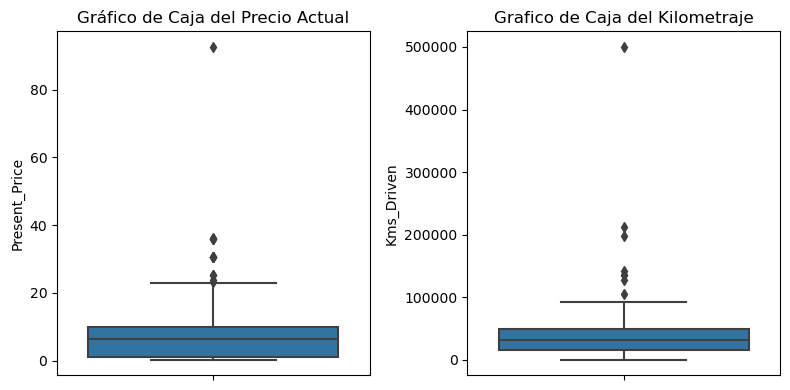

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

figura,ejes = plt.subplots(1, 2, figsize=(8,4))

sns.boxplot(y="Present_Price", data=datos, ax=ejes[0])
ejes[0].set_title('Gráfico de Caja del Precio Actual')

sns.boxplot(y="Kms_Driven", data=datos, ax=ejes[1])
ejes[1].set_title('Grafico de Caja del Kilometraje')

plt.tight_layout()
plt.show()

Por lo que queda bastante claro que existen valores atípicos que en este caso debemos de limpiar.

Esto lo haremos calculando un rango que separe los datos comúnes de los atípicos, esto se hace mediante el **Rango Intercuartilico (IQR)** al cual debemos asignarle un coeficiente $1,5$. El coeficiente $1,5$ se elige empíricamente y es ampliamente aceptado en la práctica estadística.Representa una distancia suficiente para capturar valores que son inusualmente altos/bajos. Además, tendremos que utilizar algebra lineal por lo que importaremos NumPy tambien:

In [6]:
# instalamos NumPy:
import numpy as np

# Hacer esto sera más fácil mediante una función:
def filtrador(col):
# Primero calculamos el primer(25%) y tercer(75%) cuartil:
 Q1 = datos[col].quantile(0.25)
 Q3 = datos[col].quantile(0.75)
# Calculamos el Rango Intercuartilico:
 IQR = Q3-Q1   
# Determinamos los límites para clasificar outliers: 
 limite_superior = Q3+1.5*IQR
 limite_inferior = Q1-1.5*IQR
# Ahora filtramos los datos que esten fuera de dichos límites usando NumPy: 
 datos[col] = np.where(datos[col] > limite_superior, limite_superior, 
                                   np.where(datos[col] < limite_inferior, limite_inferior, datos[col]))
    
# Claro que esta función es optimizable, sin embargo la prefiero asi por ser más ilustrativa.
    
# Ahora usemos esta función para filtrar nuestras variables:
filtrador("Present_Price")
filtrador("Kms_Driven")

Podemos utilizar nuevamente los diagrámas de caja para verificar que los *Outsiders* han sido correctamente filtrados:

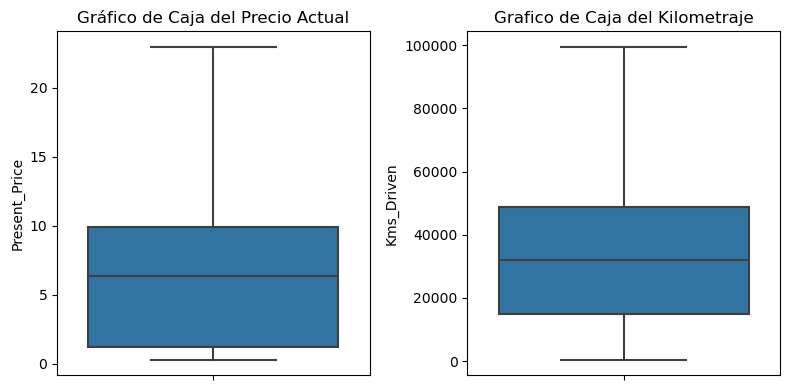

In [7]:
figura,ejes = plt.subplots(1, 2, figsize=(8,4))

sns.boxplot(y="Present_Price", data=datos, ax=ejes[0])
ejes[0].set_title('Gráfico de Caja del Precio Actual')

sns.boxplot(y="Kms_Driven", data=datos, ax=ejes[1])
ejes[1].set_title('Grafico de Caja del Kilometraje')

plt.tight_layout()
plt.show()

Para términar con el procesamiento de los datos debemos notar que existen al menos $3$ variables categóricas que pueden transformarse en variables numéricas discretas estas son `Fuel_Type`, `Seller_Type` y `Transmission`. Esto se puede hacer por dos medios distintos:
- El *Label Encoding* que es simplemente asignar un número a cada categoría, por ejemplo asignar $1$ al diesel, $2$ a la gasolina y $3$ al CNG.
- El *One Hot Encoding* se trata de sustituir cada categoría por una matriz de entradas binarias.
Para este proyecto utilizaremos este último método debido a que el label encoding puede hacer que nuestro modelo de regresión otorge un *"mayor valor"* que no se corresponde a la realidad a las categorias con un número mayor o menor asignado. Lo anterior lo podemos realizar mediante el método del mismo nombre de Sklearn.

In [8]:
# Importemos el respectivo método
from sklearn.preprocessing import OneHotEncoder

# Definamos los parámetros de nuestra función de codificación 
codificador = OneHotEncoder(sparse_output=False, drop='first')
# Aplicamos la función, lo que nos dara las columnas de sus matrices binarias
codificador_cols = codificador.fit_transform(datos[['Fuel_Type', 'Seller_Type', 'Transmission']])

# Debemos extraer las categorías de la codificación
categorias = codificador.categories_

# Establecemos los nombres em base a las categorías anteriores (a exepción de la primera)
nombres_categorias = []
for i, category_list in enumerate(categorias):
    nombres_categorias.extend([f'{datos.columns[i + 2]}_{category}' for category in category_list[1:]])

# Establecemos el DataFrame codificado
codificacion_datos =  pd.DataFrame(codificador_cols, columns=nombres_categorias)

# Concatenamos los datos con los datos codificados
datos_codificados = pd.concat([datos.drop(['Fuel_Type', 'Seller_Type', 'Transmission'], axis=1), codificacion_datos], axis=1)

# Finalmente observemos el DataFrame codificado
datos_codificados

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Present_Price_Diesel,Present_Price_Petrol,Kms_Driven_Individual,Fuel_Type_Manual
0,2014,3.35,5.59,27000.0,0,0.0,1.0,0.0,1.0
1,2013,4.75,9.54,43000.0,0,1.0,0.0,0.0,1.0
2,2017,7.25,9.85,6900.0,0,0.0,1.0,0.0,1.0
3,2011,2.85,4.15,5200.0,0,0.0,1.0,0.0,1.0
4,2014,4.60,6.87,42450.0,0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988.0,0,1.0,0.0,0.0,1.0
297,2015,4.00,5.90,60000.0,0,0.0,1.0,0.0,1.0
298,2009,3.35,11.00,87934.0,0,0.0,1.0,0.0,1.0
299,2017,11.50,12.50,9000.0,0,1.0,0.0,0.0,1.0


## 2. Regresión por medio de los Bosques Aleatorios

Realizaré una breve explicación de la regresión por medio de bosque aleatorio para entender su aplicación como método de 
`Sklearn`, que está automatizado, esto conforme avanzamos en nuestro análisis. Lo primero que debemos hacer es separar la 
variable dependiente $y$, la cual queremos predecir. Esta corresponde al **precio de venta** (es decir, la variable `Selling_Price`) de las demás variables independientes $X$ (en mayúscula pues corresponde a una matriz de datos) que utilizaremos para entrenar el modelo y como nuestros valores de entrada para obtener nuestra predicción de precios. Es por ello que codificamos las variables categóricas con el método *one-hot encoding*. Después de ello, separaremos nuestros datos entre datos de entrenamiento y de prueba para el modelo en una proporción de $80\%$ y $20\%$ respectivamente.

In [9]:
# Establecemos las variables independientes y dependientes
X = datos_codificados.drop(columns=['Selling_Price'])
y = datos_codificados['Selling_Price']

# Separamos los datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_ent, X_pru, y_ent, y_pru =  train_test_split(X, y, test_size=0.2, random_state=42)

# Observemos como son los datos de las categorias de entrenamiento
X_ent.head()

,Year,Present_Price,Kms_Driven,Owner,Present_Price_Diesel,Present_Price_Petrol,Kms_Driven_Individual,Fuel_Type_Manual
184,2008,0.750,26000.0,1,0.0,1.0,1.0,1.0
132,2017,0.950,3500.0,0,0.0,1.0,1.0,1.0
194,2008,0.787,50000.0,0,0.0,1.0,1.0,1.0
75,2015,6.800,36000.0,0,0.0,1.0,0.0,1.0
111,2016,1.500,8700.0,0,0.0,1.0,1.0,1.0


### 2.1. Bagging y CART

El bosque aleatorio, como método de aprendizaje automático, es un algoritmo que combina el resultado de varios árboles de decisión. Para ello, utiliza el método de remuestreo de **Bagging**, que genera subconjuntos de características tomados de forma aleatoria y con reemplazo. Luego, se utiliza el método de regresión con árboles de decisión en cada subconjunto.

El algoritmo que genera una regresión con un árbol de decisión se denomina **CART** y consiste en generar particiones con valores (en el caso de tener solo una variable independiente o característica) o vectores (en el caso de múltiples características). Dichas particiones se realizan utilizando el MSE y la función de costo, generando una parte de un árbol de decisión. Este proceso se repite hasta cumplir con una condición de parada preestablecida, y da como resultado un **árbol de decisión** que podemos usar para evaluar otros valores o vectores. Si quieren indagar en el algoritmo, pueden verlo en el siguiente [enlace](https://www.codificandobits.com/blog/regresion-arboles-decision-algoritmo-cart/). En nuestro caso, nuestra condición de parada será el tamaño máximo que pueden tener los árboles, que será de $11$. Veamos cómo se crea y entrena dicho modelo de regresión usando `Sklearn`.

In [10]:
# Importemos el respectivo método
from sklearn.ensemble import RandomForestRegressor

# Definimos la funcion del modelo y lo entrenamos con los datos
modelo = RandomForestRegressor(random_state=42, max_depth=11)
modelo.fit(X_ent, y_ent)

RandomForestRegressor(max_depth=11, random_state=42)

### 2.2. Predicciones y Medidas de Error

El resultado del CART es un árbol de decisión en el cual, para realizar pronósticos, solo tendremos que introducir un valor $\overline{x}\in{X}$ y obtener la hoja resultante. En nuestro caso, los datos que vamos a introducir son los datos de categoría de prueba y validación `X_pru`. Claro que, al tener el bosque aleatorio varios árboles de decisión resultantes, la imagen resultante no será la hoja de un árbol particular, sino más bien un promedio entre dichas hojas. Para medir qué tan acertados fueron dichos pronósticos, disponemos de varias métricas, entre ellas el coeficiente de correlación *R cuadrado*, el error cuadrático medio *MSE* y el error absoluto medio *MAE*. En nuestro caso, utilizaremos las tres y compararemos nuestros resultados con los valores reales de prueba `y_pru`.  

In [11]:
# Realicemos el pronóstico del modelo
y_pred = modelo.predict(X_pru)

# Importemos las métricas de error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Determinamos el error según cada métrica (función práctica):
def calculadora_error(a, b):
    mse = mean_squared_error(a, b)
    mae = mean_absolute_error(a, b)
    r2 = r2_score(a, b)
    print(f'Error cuadrático medio (MSE): {round(mse, 5)}')
    print(f'Error absoluto medio (MAE): {round(mae, 5)}')
    print(f'Coeficiente de determinación $r^2$: {round(r2, 5) * 100}%')
    
# Usemos la función que creamos antes para determinar el error
calculadora_error(y_pru, y_pred)

Error cuadrático medio (MSE): 1.54604
Error absoluto medio (MAE): 0.7049
Coeficiente de determinación $r^2$: 93.28800000000001%


### 2.3. Optimización del Modelo por Hiperparámetros

Viendo el resultado de nuestras medidas de error anteriores, podemos preguntarnos ¿cómo podemos mejorar nuestro modelo? Una de las posibles formas de hacer esto es mediante la búsqueda de los hiperparámetros más óptimos. Con hiperparámetros nos referimos a los parámetros que utiliza el método, ya sea algorítmico o computacional. Sklearn posee una función automatizada de búsqueda aleatoria para dichos parámetros; solo debemos establecer una **variable aleatoria discreta uniforme** en un rango de búsqueda de los hiperparámetros, esto se hace con Scipy.

In [12]:
# Importamos las funciones de busqueda y de variable aleatoria
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Definimos la distribución de los parámetros para la busqueda aleatoria
distribucion_parametros = {
    'max_depth': randint(1, 50),  
    'n_estimators': randint(10, 100),  
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 10),  
}

# Definimos el modelo que vamos a ajustar
modelo = RandomForestRegressor()  # Aquí puedes usar el modelo que prefieras

# Establecemos las metricas necesarias para tener un criterio en la busqueda aleatoria
metricas = {'mse': 'neg_mean_squared_error', 'r2': 'r2'}

# Ahora definimos el modelo y realizamos el entrenamiento
busqueda_aleatoria = RandomizedSearchCV(estimator=modelo, param_distributions=distribucion_parametros, n_iter=100, cv=5, random_state=42, scoring=metricas, refit='mse')
busqueda_aleatoria.fit(X_ent, y_ent)

# Obtendremos los hiperparámetros como una propiedad de la función anterior, así también podremos saber cuáles son
parametros = busqueda_aleatoria.best_params_
print(f'Hiperparámetros obtenidos de la busqueda aleatoria: {parametros}')

Hiperparámetros obtenidos de la busqueda aleatoria: {'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 26}


Por último, podremos volver a entrenar nuestro modelo, solo que esta vez con los hiperparámetros que encontramos, para realizar el mejor modelo de regresión posible por este método. Para verificar que esta versión es mejor, usaremos otra vez las métricas de antes.

In [13]:
# De nuevo obtenemos el modelo con los hiperparametros ya integrados como propiedad de la busqueda aleatoria
modelo_mejorado = busqueda_aleatoria.best_estimator_

# Al igual que antes realizamos el pronóstico, esta vez con el modelo mejorado
y_pred = modelo_mejorado.predict(X_pru)

# Veamos si las métricas de error presentan una mejora con respecto al anterior
calculadora_error(y_pru, y_pred)

Error cuadrático medio (MSE): 0.97004
Error absoluto medio (MAE): 0.61936
Coeficiente de determinación $r^2$: 95.789%


## 2.4. Comparación Gráfica

Aunque las métricas de error ya nos proporcionaron información acerca de qué tan acertados son los pronósticos de nuestro modelo, tal vez esto no sea ideal al momento de explicar o ilustrar la efectividad o los fallos del mismo para un grupo de trabajo u otras personas en general. Por ello, de manera complementaria, podemos realizar una gráfica que compare directamente los valores de prueba con los predichos por la regresión.

Antes de eso debemos organizar y transformar nuestros datos para poderlos gráficar:

In [14]:
# Importemos Pandas para transformar los datos del prónostico y poderlos graficar
import pandas as pd

# Las predicciones del modelo estan en formato 'array' de pandas asi que debemos transformarlo en una serie de
# Pandas
y_pred = pd.Series(y_pred)
# Como mencionamos antes, los valores índice de la serie de validación estan mal ordenados asi que debemos resetearlo
y_pru = y_pru.reset_index(drop=True)

Una vez hecho lo anterior, podemos realizar la gráfica comparativa usand MatPlotLib.

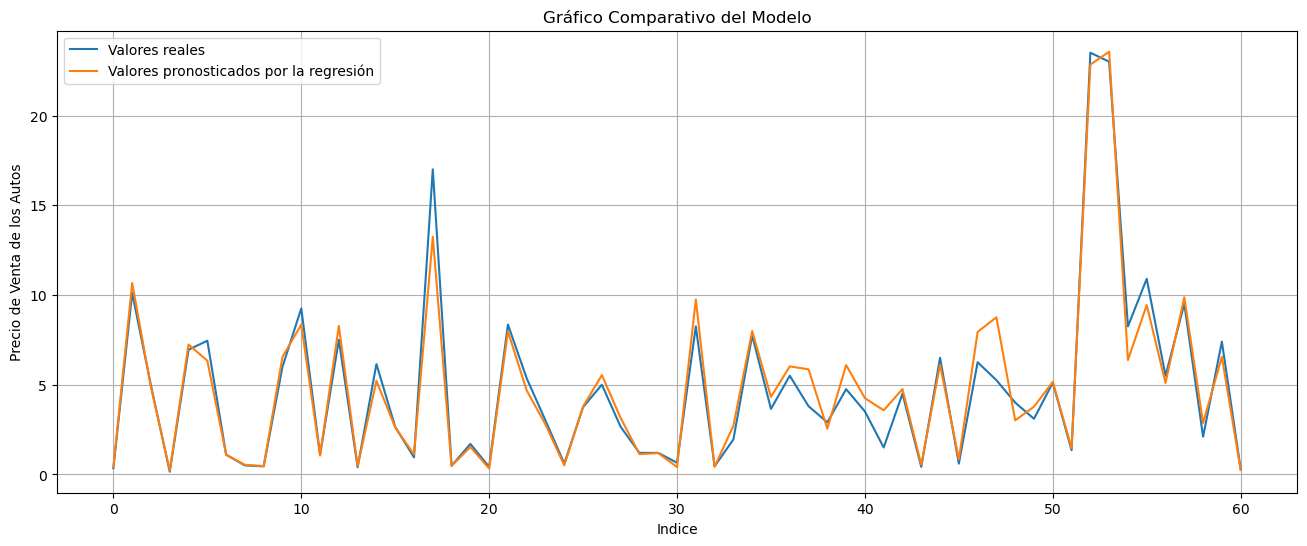

In [15]:
# Importemos el paquete necesario para crear las gráficas
import matplotlib.pyplot as plt

# Realicemos el gráfico
plt.figure(figsize=(16,6))

plt.plot(y_pru.index, y_pru, label='Valores reales')
plt.plot(y_pred.index, y_pred, label='Valores pronosticados por la regresión')

plt.xlabel('Indice')
plt.ylabel('Precio de Venta de los Autos')

plt.title('Gráfico Comparativo del Modelo')
plt.legend()
plt.grid(True)
plt.show()

# 3. Conclusiones y Notas

Para terminar, queda claro que el modelo de regresión por medio de bosque aleatorio se ajusta de manera precisa a los datos y es capaz de pronosticar, en un grado aceptable, los precios de venta de un auto en base a las categorías de las que disponíamos (tipo de combustible, kilómetros recorridos, etc.). De manera más formal, el coeficiente de determinación $r^2$ determina qué tan bien predice la variabilidad un modelo, donde $0\%$ significa que el modelo no explica nada de la variable dependiente y un $100\%$ que el modelo explica perfectamente las variaciones de la variable. Nuestro modelo tiene un $r^2\approx95\%$, lo cual está bien e implica que nuestro modelo tiene capacidad de realizar pronósticos satisfactorios. Sin embargo, se debe tener cuidado, pues un coeficiente tan alto puede implicar un sobreajuste a los datos.

Voy a realizar un artículo o post a futuro hablando más a detalle del uso para regresión y clasificación de los bosques aleatorios y los árboles de decisión. Realmente me sorprendió el nivel de exactitud del modelo, esto teniendo en cuenta que es la primera vez que lo uso de forma práctica con métodos computacionales. Además, me parece que, aunque el ajuste de hiperparámetros mejoró el modelo, esto no fue muy significativo, ya que el coeficiente $r^2$ solo aumentó un $2\%$ aproximadamente, teniendo en cuenta el coste computacional extra que tiene ese proceso. Cabe mencionar que esa última parte de ajuste de hiperparámetros fue aquella cuyo código tardó más en ejecutarse y además con una diferencia significativa.

Como se puede notar, a diferencia de los demás proyectos en este portafolio, este está organizado de manera diferente. Esto se debe a que en este me enfoqué más en presentar la información de manera más didáctica e ilustrativa. Evidentemente, todo lo hecho anteriormente se puede hacer de manera mucho más eficiente con menos líneas de código, pero, al menos para estos proyectos más centrados en ser auto-explicativos, me gusta más este enfoque.